In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

import duckdb

conn = duckdb.connect('/global/scratch/users/empchase/Seq_analysis/mydb.db') # create an in-memory database

In [3]:
exp = 'AD_4_15_20X20_S8_L004.fastq.gz.assembled.fastq'
a10design = '/global/scratch/users/empchase/A10_sequencing/analysis/a10_designfile.csv'
a11design = 'a11_designfile.csv'

In [4]:
#get list of designed tiles

a10dt = []

with open(a10design, 'r') as f:
    for line in f:
        if "ArrayDNA" in line:
            pass
        else:
            a10dt.append(line.strip())
# print(a10dt[:5])
print(len(a10dt))#20783

#create a dictionary of values
dtiles = {}
for i in a10dt:
    dtiles[i] = 1
    
# print(d)

20783


In [5]:
#get list of designed tiles

a11dt = []

with open(a11design, 'r') as f:
    for line in f:
        if "ArrayDNA" in line:
            pass
        else:
            a11dt.append(line.strip())
# print(a10dt[:5])
print(len(a11dt))#20783

#create a dictionary of values
d11tiles = {}
for i in a11dt:
    d11tiles[i] = 1
    
# print(d)

18843


In [6]:
def complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N':'N', 'X':'X'} 
    bases = list(seq) 
    bases = [complement[base] for base in bases] 
    return ''.join(bases)
def reverse_complement(s):
        return complement(s[::-1])

In [7]:
def getmid(seq, pre, post):
    # seq = the sequence to parse
    # pre = substring that precedes piece of interest
    # post = substring that follows piece of interest
    # returns piece of interest
    
    re_key = pre + "(.*)"+ post
    poi_search = re.search(re_key, seq)
#     print(poi_search)
    if poi_search is None:
        poi = "X"
    else:
        poi = poi_search.group(1)
    
    return poi

adp = 'CGGGCCC'#7 bp ; beforeAD barcode in read1
adf = 'GGCGCGC' #7bp ; after AD barcode in read1 GGCGCGC

def a10tilebc_mapper(readfile, tile_pre = "TAGTCA", tile_post = "GCTAGC", 
                  adBC_pre = adp, adBC_post = adf):
    
    #readfile = file of SEQUENCES ONLY
    # *_pre or *_post = the consensus sequences before or after each feature

    # make lists of reads
    readlist = []

    
    with open(readfile, 'r') as fin:
        for line in fin:
            if line.startswith('@'):
                #look at next line to get read sequence, add to list
                seq = next(fin)
                seq = seq.strip()
                readlist.append(seq)
                
    #make lists of tiles/BCs from list of reads
    tile_list = []
    tile_lengths= []
    
    des_query = [] # tells us if tile matches design or not
    
    adBC_list = []
    adBC_lengths = []
   
    
    for read in readlist:
        tile = getmid(read, tile_pre, tile_post) #use consensus seq to find tile
        tile = reverse_complement(tile)
        tile_list.append(tile) #add tile to list
        tile_len = len(tile) #find length of tile
        tile_lengths.append(tile_len) #add length to list
            
        if tile in dtiles:
            des_query.append(1)
        else:
            des_query.append(0)
#         print(tile)
        
        adBC = getmid(read, adBC_pre, adBC_post)
        adBC = reverse_complement(adBC)
        adBC_list.append(adBC)
        adBC_len = len(adBC)
        adBC_lengths.append(adBC_len)

            
    # make the df
    
    tileBC_dict = {"Reads":readlist, "Tiles":tile_list, "T Len" : tile_lengths, "Designed": des_query, 
                  "AD BCs":adBC_list, "A Len": adBC_lengths}
    tileBC_df = pd.DataFrame.from_dict(tileBC_dict)
    
    return tileBC_df

In [8]:
expmap = a10tilebc_mapper(exp)
expmap

,Reads,Tiles,T Len,Designed,AD BCs,A Len
0,ANAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTAG...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1,ACGCCCACCTG,11
1,ANTATAAGAAATTCGCGGGCCCGTTTACCCGGTGGCGCGCCTCAGC...,AATGAATCTCCAGAATATAATGATGGATTTGATGCTTCTCCATTTG...,120,1,ACCGGGTAAAC,11
2,TNTAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTA...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1,ACGCCCACCTG,11
3,TNTAAGAAATTCGCGGGCCCATGTGCCAGGTGGCGCGCCTCAGCTA...,ATTTATAATCCAGAAGATTCTGAATCTGTTAAGAGAGCTATAAATA...,120,0,ACCTGGCACAT,11
4,ATAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTAG...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1,ACGCCCACCTG,11
...,...,...,...,...,...,...
3701179,TATAAGAAATTCGCGGGCCCGGTGGAGTAGCGGCGCGCCTCAGCTA...,AAGAAACAAAGATCTCAACCATTGCCACCAGTTGCTACTGAATCTA...,120,1,GCTACTCCACC,11
3701180,CTATAAGAAATTCGCGGGCCCTTGTTGGATGCGGCGCGCCTCAGCT...,ACTGGATCTCCACAAGATTTTTGATTCAA,29,0,GCATCCAACAA,11
3701181,TATAAGAAATTCGCGGGCCCAAAATAGTTAGGGCGCGCCTCAGCTA...,TTCTCTCCATTGACTGGTGTTCATGATACTTCTTCTCCATCTATTG...,118,0,CTAACTATTTT,11
3701182,ACTATAAGAAATTCGCGGGCCCTTGTTGGATGCGGCGCGCCTCAGC...,ACTGGATCTCCACAAGATTTTTGATTCAA,29,0,GCATCCAACAA,11


In [9]:
expmap[expmap['Designed']==1]

,Reads,Tiles,T Len,Designed,AD BCs,A Len
0,ANAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTAG...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1,ACGCCCACCTG,11
1,ANTATAAGAAATTCGCGGGCCCGTTTACCCGGTGGCGCGCCTCAGC...,AATGAATCTCCAGAATATAATGATGGATTTGATGCTTCTCCATTTG...,120,1,ACCGGGTAAAC,11
2,TNTAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTA...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1,ACGCCCACCTG,11
4,ATAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTAG...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1,ACGCCCACCTG,11
7,CTATAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCT...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1,ACGCCCACCTG,11
...,...,...,...,...,...,...
3701169,TAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTAGT...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1,ACGCCCACCTG,11
3701170,ATAAGAAATTCGCGGGCCCGGTGGAGTAGCGGCGCGCCTCAGCTAG...,AAGAAACAAAGATCTCAACCATTGCCACCAGTTGCTACTGAATCTA...,120,1,GCTACTCCACC,11
3701173,ATAAGAAATTCGCGGGCCCAATCAAATTACGGCGCGCCTCAGCTAG...,TTTGATTCTCCAGATGTTGCTGAATCATTTGAAACTTCTCCATTGT...,120,1,GTAATTTGATT,11
3701175,ACTATAAGAAATTCGCGGGCCCATTTAACCTCAGGCGCGCCTCAGC...,ACTCCAGCTGTTTCTAGAGCTCCAGCTGCTTCTGCTTCTCCAGTTG...,120,1,TGAGGTTAAAT,11


In [10]:
expmap[expmap['T Len']==120]

,Reads,Tiles,T Len,Designed,AD BCs,A Len
0,ANAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTAG...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1,ACGCCCACCTG,11
1,ANTATAAGAAATTCGCGGGCCCGTTTACCCGGTGGCGCGCCTCAGC...,AATGAATCTCCAGAATATAATGATGGATTTGATGCTTCTCCATTTG...,120,1,ACCGGGTAAAC,11
2,TNTAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTA...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1,ACGCCCACCTG,11
3,TNTAAGAAATTCGCGGGCCCATGTGCCAGGTGGCGCGCCTCAGCTA...,ATTTATAATCCAGAAGATTCTGAATCTGTTAAGAGAGCTATAAATA...,120,0,ACCTGGCACAT,11
4,ATAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTAG...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1,ACGCCCACCTG,11
...,...,...,...,...,...,...
3701174,TAAGAAATTCGCGGGCCCATTCGCTGTTCGGCGCGCCTCAGCTAGT...,GGTACTGTATCTCCACAAGATTTGTTGATTCAAGAACCATTTATGT...,120,0,GAACAGCGAAT,11
3701175,ACTATAAGAAATTCGCGGGCCCATTTAACCTCAGGCGCGCCTCAGC...,ACTCCAGCTGTTTCTAGAGCTCCAGCTGCTTCTGCTTCTCCAGTTG...,120,1,TGAGGTTAAAT,11
3701176,TATAAGAAATTCGCGGGCCCATGTGCCAGGTGGCGCGCCTCAGCTA...,ATTTATAATCCAGAAGATTCTGAATCTGTTAAGAGAGCTATAAATA...,120,0,ACCTGGCACAT,11
3701177,CTATAAGAAATTCGCGGGCCCATGTGCCAGGTGGCGCGCCTCAGAT...,ATTTATAATCCAGAAGATTCTGAATCTGTTAAGAGAGCTATAAATA...,120,0,ACCTGGCACAT,11


In [11]:
expmap.describe()

,T Len,Designed,A Len
count,3.701184e+06,3.701184e+06,3.701184e+06
mean,1.099953e+02,5.225352e-01,1.063373e+01
std,3.018144e+01,4.994920e-01,1.890057e+00
min,1.000000e+00,0.000000e+00,1.000000e+00
25%,1.190000e+02,0.000000e+00,1.100000e+01
50%,1.200000e+02,1.000000e+00,1.100000e+01
75%,1.200000e+02,1.000000e+00,1.100000e+01
max,1.950000e+02,1.000000e+00,1.630000e+02


In [12]:
x = expmap.loc[0, 'Reads']
getmid(x, 'TAGTCA', 'GCTAGC')

'AGTATCAATAATTGGAGTAGACAAATTAGATTGAGTTGGAGTAAACAATTGTTTAGGAGCAGTTGGTTCCAATTCTGGTTCAATAGATTCTTCAATAGTTTCAAATGTATCAACTTCAGA'

1933999 / 3.7 M = 52% of reads have an a10 designed tile

Next: check against a11_design

In [13]:
# def a11tilebc_mapper(readfile, tile_pre = "TAGTCA", tile_post = "GCTAGC", 
#                   adBC_pre = adp, adBC_post = adf):
    
#     #readfile = file of SEQUENCES ONLY
#     # *_pre or *_post = the consensus sequences before or after each feature

#     # make lists of reads
#     readlist = []

    
#     with open(readfile, 'r') as fin:
#         for line in fin:
#             if line.startswith('@'):
#                 #look at next line to get read sequence, add to list
#                 seq = next(fin)
#                 seq = seq.strip()
#                 readlist.append(seq)
                
#     #make lists of tiles/BCs from list of reads
#     tile_list = []
#     tile_lengths= []
    
#     des_query = [] # tells us if tile matches design or not
    
#     adBC_list = []
#     adBC_lengths = []
   
    
#     for read in readlist:
#         tile = getmid(read, tile_pre, tile_post) #use consensus seq to find tile
#         tile = reverse_complement(tile)
#         tile_list.append(tile) #add tile to list
#         tile_len = len(tile) #find length of tile
#         tile_lengths.append(tile_len) #add length to list
            
#         if tile in d11tiles:
#             des_query.append(1)
#         else:
#             des_query.append(0)
# #         print(tile)
        
#         adBC = getmid(read, adBC_pre, adBC_post)
#         adBC = reverse_complement(adBC)
#         adBC_list.append(adBC)
#         adBC_len = len(adBC)
#         adBC_lengths.append(adBC_len)

            
#     # make the df
    
#     tileBC_dict = {"Reads":readlist, "Tiles":tile_list, "T Len" : tile_lengths, "Designed": des_query, 
#                   "AD BCs":adBC_list, "A Len": adBC_lengths}
#     tileBC_df = pd.DataFrame.from_dict(tileBC_dict)
    
#     return tileBC_df

In [14]:
# expmap2 = a11tilebc_mapper(exp)
# expmap2

In [15]:
# expmap2.loc[0, 'Tiles']

In [16]:
# expmap2[expmap2['Designed']==1]

In [17]:
# testa11tile = 'CCATTGACTCATGATAAGACTGCTAGAGATTTGCCACAATTGTCTTCTCAATTAAATTCTATTCCATATTATTCTGCTCCACATGATCCATCTACTAGACATCATTATTTGAATGTTGCT'
# # d11tiles[testa11tile]

# if testa11tile in d11tiles:
#     print ('hi')

In [18]:
# testexptile = 'TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAGAATTGGAACCAACTGCTCCTAAACAATTGTTTACTCCAACTCAATCTAATTTGTCTACTCCAATTATTGATACT'
# # d11tiles[testexptile]

# if testexptile in d11tiles:
#     print ('hi')

In [19]:
# len(testa11tile)

In [61]:
conn.sql('SHOW ALL TABLES')

┌──────────┬─────────┬─────────────┬───────────────────────────┬──────────────────────────────────────┬───────────┐
│ database │ schema  │    name     │       column_names        │             column_types             │ temporary │
│ varchar  │ varchar │   varchar   │         varchar[]         │              varchar[]               │  boolean  │
├──────────┼─────────┼─────────────┼───────────────────────────┼──────────────────────────────────────┼───────────┤
│ mydb     │ main    │ SI_VI_AD0   │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_AD1   │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_RPTR0 │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_RPTR1 │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ TBB         │ [Tiles, ADbc, RPTRbc]     │ [VARCHA

In [63]:
tbb = conn.sql('SELECT * FROM TBB_UNION').df()
tbb.head()

,Tile,ADbc,RPTRbc,TBB
0,GATTTGCAAGGTAAATTCTTGGCTGCTCCATTGGAAGAGAATCCAA...,TTTATCCTCGG,AAAAAATTACTTGG,GATTTGCAAGGTAAATTCTTGGCTGCTCCATTGGAAGAGAATCCAA...
1,GACCCATATATGTCTGCTCCAAATTCTACTGCATTTACTGCTTTGA...,TGAAATGGTAA,CAAAAAGCTATGGT,GACCCATATATGTCTGCTCCAAATTCTACTGCATTTACTGCTTTGA...
2,GCTTTGGCTGGTGATCCATGGTATCCATTGTTTCCACAAGATGATC...,TGGTAATGAGA,TTTAAATGGCTAAT,GCTTTGGCTGGTGATCCATGGTATCCATTGTTTCCACAAGATGATC...
3,GATTATCATTCTCAAGCTACTGCTGACTTTGTCTTGTATCCACAAG...,AAGGTCCGAGG,AACAAATACAGAGT,GATTATCATTCTCAAGCTACTGCTGACTTTGTCTTGTATCCACAAG...
4,GATATTGAAGCTAGATCATTCTATGTCTTTGGTTCTCCAGTTTCTC...,CCCCGCCGTCG,TCTAGGTTTCACCC,GATATTGAAGCTAGATCATTCTATGTCTTTGGTTCTCCAGTTTCTC...


In [22]:
tcountdf = expmap['Tiles'].value_counts().to_frame().reset_index()
tcountdf

,index,Tiles
0,AAGAAACAAAGATCTCAACCATTGCCACCAGTTGCTACTGAATCTA...,283382
1,CCAGCTCAAGTTATTCAAAGACCACAAAGAGCTCCATCTGCTCCAC...,271204
2,AATGAATCTCCAGAATATAATGATGGATTTGATGCTTCTCCATTTG...,266882
3,ATTTATAATCCAGAAGATTCTGAATCTGTTAAGAGAGCTATAAATA...,244551
4,AGACAACTCATAATTCTAGAATTGCTGTTCCATCTCAAAGAAGACA...,238505
...,...,...
34738,TTTGATTCTCCAGATGTTGCTGAATCATTTGAAACTTCTCCAATGT...,1
34739,AAGTAACAAAGATCTCAACCATTGCAACCAGTTGCTACTGAATCTA...,1
34740,CCAGCTCAAGATATTCAAAGACCACAAAGAGCTCCATCTGCTCCAC...,1
34741,AGATCTGGTACTTGTACTTCTCCACCAGCTACTTCTCATTCTTCTG...,1


In [23]:
tcountdf.head(50)

,index,Tiles
0,AAGAAACAAAGATCTCAACCATTGCCACCAGTTGCTACTGAATCTA...,283382
1,CCAGCTCAAGTTATTCAAAGACCACAAAGAGCTCCATCTGCTCCAC...,271204
2,AATGAATCTCCAGAATATAATGATGGATTTGATGCTTCTCCATTTG...,266882
3,ATTTATAATCCAGAAGATTCTGAATCTGTTAAGAGAGCTATAAATA...,244551
4,AGACAACTCATAATTCTAGAATTGCTGTTCCATCTCAAAGAAGACA...,238505
5,GCTTTGACTTCTCCATCTTTGTATGAATCTCCAGACTTTGGTTATG...,234727
6,AGATCTGGTACTTCTACTTCTCCACCAGCTACTTCTCATTCTTCTG...,233946
7,TTCTCTCCATTGACTGGTGTTCATGATACTTCTTCTCCATCTATTG...,227850
8,ACTCCAGCTGTTTCTAGAGCTCCAGCTGCTTCTGCTTCTCCAGTTG...,226243
9,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,218313


In [24]:
# #plot tiles as histogram

# plt.figure()
# plt.hist(tcountdf['Tiles'] #, bins=500 #, range=[10,20]
#         )
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Coverage')
# plt.ylabel('Counts')
# # plt.title("4_30_0 3'Restriction Sites")

# plt.show()

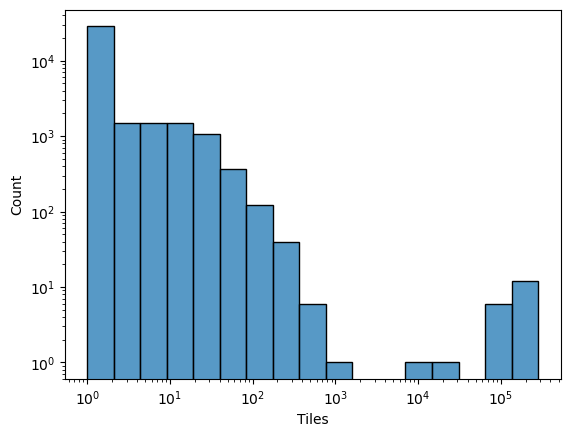

In [25]:
sns.histplot(data=tcountdf, x='Tiles', log_scale = (True, True))
plt.show()

In [54]:
#clean expmap

expmap_clean = expmap.replace(0, np.nan)
expmap_clean = expmap_clean.dropna().reset_index()
expmap_clean

,index,Reads,Tiles,T Len,Designed,AD BCs,A Len
0,0,ANAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTAG...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1.0,ACGCCCACCTG,11
1,1,ANTATAAGAAATTCGCGGGCCCGTTTACCCGGTGGCGCGCCTCAGC...,AATGAATCTCCAGAATATAATGATGGATTTGATGCTTCTCCATTTG...,120,1.0,ACCGGGTAAAC,11
2,2,TNTAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTA...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1.0,ACGCCCACCTG,11
3,4,ATAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTAG...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1.0,ACGCCCACCTG,11
4,7,CTATAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCT...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1.0,ACGCCCACCTG,11
...,...,...,...,...,...,...,...
1933994,3701169,TAAGAAATTCGCGGGCCCCAGGTGGGCGTGGCGCGCCTCAGCTAGT...,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,120,1.0,ACGCCCACCTG,11
1933995,3701170,ATAAGAAATTCGCGGGCCCGGTGGAGTAGCGGCGCGCCTCAGCTAG...,AAGAAACAAAGATCTCAACCATTGCCACCAGTTGCTACTGAATCTA...,120,1.0,GCTACTCCACC,11
1933996,3701173,ATAAGAAATTCGCGGGCCCAATCAAATTACGGCGCGCCTCAGCTAG...,TTTGATTCTCCAGATGTTGCTGAATCATTTGAAACTTCTCCATTGT...,120,1.0,GTAATTTGATT,11
1933997,3701175,ACTATAAGAAATTCGCGGGCCCATTTAACCTCAGGCGCGCCTCAGC...,ACTCCAGCTGTTTCTAGAGCTCCAGCTGCTTCTGCTTCTCCAGTTG...,120,1.0,TGAGGTTAAAT,11


In [27]:
tilecounts_clean = expmap_clean['Tiles'].value_counts().to_frame().reset_index()
tilecounts_clean

,index,Tiles
0,AAGAAACAAAGATCTCAACCATTGCCACCAGTTGCTACTGAATCTA...,283382
1,CCAGCTCAAGTTATTCAAAGACCACAAAGAGCTCCATCTGCTCCAC...,271204
2,AATGAATCTCCAGAATATAATGATGGATTTGATGCTTCTCCATTTG...,266882
3,GCTTTGACTTCTCCATCTTTGTATGAATCTCCAGACTTTGGTTATG...,234727
4,ACTCCAGCTGTTTCTAGAGCTCCAGCTGCTTCTGCTTCTCCAGTTG...,226243
5,TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAG...,218313
6,TTTGATTCTCCAGATGTTGCTGAATCATTTGAAACTTCTCCATTGT...,133616
7,GGTACTGTTTCTCCACAAGATTTGTTGATTCAAGAACCATTTATGT...,133345
8,AGAACTATTTCTTCTCAATCTATGGAAAGATCTGGTTCTTCTTCTT...,127196
9,TCTACTGATTATCAAGGTTTGCCATCTGACTTCTCTCCATTGACTG...,25269


In [28]:
# #plot tiles as histogram

# plt.figure()
# plt.hist(tilecounts_clean['Tiles'] #, bins=12 #, range=[10,20]
#         )
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Coverage')
# plt.ylabel('Counts')
# # plt.title("4_30_0 3'Restriction Sites")

# plt.show()

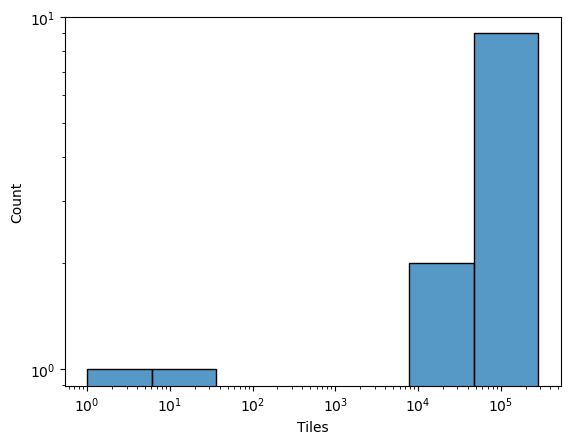

In [29]:
sns.histplot(data=tilecounts_clean, x='Tiles', log_scale = (True, True))
plt.show()

In [73]:
for i in range(10):
    ti ,ab = expmap_clean.loc[i, ['Tiles', 'AD BCs']]
    print(ti, ab)
    print(
        conn.sql(
            "SELECT * FROM TBB_UNION WHERE TILE='{tilequery}' AND ADBC ='{adbcquery}' ".format(
                tilequery = ti, adbcquery = ab)))
    

TCTGAAGTTGATACATTTGAAACTATTGAAGAATCTATTGAACCAGAATTGGAACCAACTGCTCCTAAACAATTGTTTACTCCAACTCAATCTAATTTGTCTACTCCAATTATTGATACT ACGCCCACCTG
┌──────────────────────┬─────────────┬────────────────┬────────────────────────────────────────────────────────────────┐
│         Tile         │    ADbc     │     RPTRbc     │                              TBB                               │
│       varchar        │   varchar   │    varchar     │                            varchar                             │
├──────────────────────┼─────────────┼────────────────┼────────────────────────────────────────────────────────────────┤
│ CAATTGCAACAATTGCAA…  │ ACGCCCACCTG │ CGCCCACAAGCCAC │ CAATTGCAACAATTGCAACAATTCTATCAAAGAAGAATTATGTCTACTCCAAATATTGGT…  │
│ CCATCTGGTTCTAGAGCT…  │ ACGCCCACCTG │ ATGACGCGGGTCTA │ CCATCTGGTTCTAGAGCTTCTTTGTCTGGTGTTTCTTCTAGGAAGAGAGATAAACCATTG…  │
│ ATGCAACAAGGTACTTTG…  │ ACGCCCACCTG │ CTCTATCTCGCGCA │ ATGCAACAAGGTACTTTGTCTTCTTTGGACTTTGTTGCTTCTCCAACATTTAATCATAAA…  │
│ TCTGAAGTTGATACATTT

┌──────────────────────┬─────────────┬────────────────┬────────────────────────────────────────────────────────────────┐
│         Tile         │    ADbc     │     RPTRbc     │                              TBB                               │
│       varchar        │   varchar   │    varchar     │                            varchar                             │
├──────────────────────┼─────────────┼────────────────┼────────────────────────────────────────────────────────────────┤
│ TCTAAGAAACAATTTCAA…  │ GACTCTGATGC │ ACATTTGAGAAAAA │ TCTAAGAAACAATTTCAATTGGTTACTCCAAATCCATCTTCTACTTTGCCAACTCCATTG…  │
│ GCTAGAAGATCTAGAGCT…  │ GACTCTGATGC │ GCCGCTGCGGCACC │ GCTAGAAGATCTAGAGCTAGGAAAGTTGAAAGAATGAATCAATTGGAAGATAAAGTTGAA…  │
│ GATTCATTTGAATGTTCT…  │ GACTCTGATGC │ CCTGAGAACATCTG │ GATTCATTTGAATGTTCTCCAATGTTTAATGGTGAACCAAATATGACTGATACTTCTGAT…  │
└──────────────────────┴─────────────┴────────────────┴────────────────────────────────────────────────────────────────┘

GCTTTGACTTCTCCATCTTTGTATGAATCTC

In [64]:
tbb.shape

(12089998, 4)

In [62]:
# conn.sql("CREATE TABLE TBB_NOV2023 AS SELECT DISTINCT * FROM TBB")

CatalogException: Catalog Error: Table with name "TBB_NOV2023" already exists!

In [65]:
conn.sql("SELECT COUNT(*) FROM TBB_NOV2023")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│     28241827 │
└──────────────┘

In [66]:
conn.sql("SHOW ALL TABLES")

┌──────────┬─────────┬─────────────┬───────────────────────────┬──────────────────────────────────────┬───────────┐
│ database │ schema  │    name     │       column_names        │             column_types             │ temporary │
│ varchar  │ varchar │   varchar   │         varchar[]         │              varchar[]               │  boolean  │
├──────────┼─────────┼─────────────┼───────────────────────────┼──────────────────────────────────────┼───────────┤
│ mydb     │ main    │ SI_VI_AD0   │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_AD1   │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_RPTR0 │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_RPTR1 │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ TBB         │ [Tiles, ADbc, RPTRbc]     │ [VARCHA